Credit: Pere Gilabert (UB)

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

In [ ]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

# Problem: Reversed sequences
Given $X = [1,2,3,4,5]$ we want to predict $y = [5,4,3,2,1]$

## 1. Create the dataset

In [ ]:
n_timesteps_in = 4  # Sequence length
n_features = 10     # Maximum number allowed-1 (length of the one-hot-encoded vector)

train_size = 2000 
test_size = 200

X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

In [ ]:
print(f'Example:\nSequence {one_hot_decode(X_train[0])} is encoded as:\n\nX={X_train[0]}\n\ny={y_train[0]}')

Example:
Sequence [9, 8, 5, 8] is encoded as:

X=[[0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]

y=[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]


## 2. LSTM parameters

- `return_sequences=False, return_state=False`: return the last hidden state: state_h
- `return_sequences=True, return_state=False`: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- `return_sequences=False, return_state=True`: return 3 arrays: state_h, state_h, state_c
- `return_sequences=True, return_state=True`: return 3 arrays: stacked hidden states, last state_h, last state_c

## 3. Model architecture: Simple Encoder-Decoder using LSTM

In [ ]:
def build_model(batch_size, rnn_units):
    """
    Builds the model.
    
    :batch_size: Samples per batch.
    :rnn_units: Number of units in the LSTM cell
    """
    
    # ENCODER STEP
    # ------------
    # Encoder with input (timesteps, features).
    # LSTM return_state param will return last hidden state and last cell state
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    # initial context vector for the decoder (is the last output of the encoder)
    states = [state_h, state_c]

    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')

    all_outputs = []
    # Prepare decoder input data.
    # First input will be a sequence full of zeroes.
    inputs = np.zeros((batch_size, 1, n_features))
        
    # decoder will only process one timestep at a time.
    for _ in range(n_timesteps_in):
        # Run the decoder on one timestep
        outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = tf.expand_dims(outputs, 1)
        outputs = decoder_dense(outputs)
        
        # Store the current prediction (we will concatenate all predictions later)
        all_outputs.append(outputs)
        
        # Reinject the outputs as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    # Concatenate all predictions such as [batch_size, timesteps, features]
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

    # Define and compile model 
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
batch_size = 10
rnn_units = 16
model_encoder_decoder = build_model(batch_size=batch_size, rnn_units=rnn_units)
model_encoder_decoder.summary()

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 4, 10)]      0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 16),         1728        ['encoder_inputs[0][0]']         
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 decoder_lstm (LSTM)            [(10, 16),           1728        ['encoder_lstm[0][1]',           
                                 (None, 16),                      'encoder_lst

Epoch 1/25
180/180 [==============================] - 10s 17ms/step - loss: 2.1648 - accuracy: 0.2340 - val_loss: 1.9362 - val_accuracy: 0.2938
Epoch 2/25
180/180 [==============================] - 1s 5ms/step - loss: 1.7519 - accuracy: 0.3629 - val_loss: 1.6040 - val_accuracy: 0.3800
Epoch 3/25
180/180 [==============================] - 1s 6ms/step - loss: 1.5378 - accuracy: 0.3999 - val_loss: 1.4923 - val_accuracy: 0.3900
Epoch 4/25
180/180 [==============================] - 1s 6ms/step - loss: 1.4468 - accuracy: 0.4125 - val_loss: 1.4177 - val_accuracy: 0.4062
Epoch 5/25
180/180 [==============================] - 1s 6ms/step - loss: 1.3720 - accuracy: 0.4286 - val_loss: 1.3608 - val_accuracy: 0.4075
Epoch 6/25
180/180 [==============================] - 1s 6ms/step - loss: 1.3023 - accuracy: 0.4465 - val_loss: 1.3009 - val_accuracy: 0.4412
Epoch 7/25
180/180 [==============================] - 1s 6ms/step - loss: 1.2271 - accuracy: 0.4800 - val_loss: 1.2294 - val_accuracy: 0.4813
Epoc

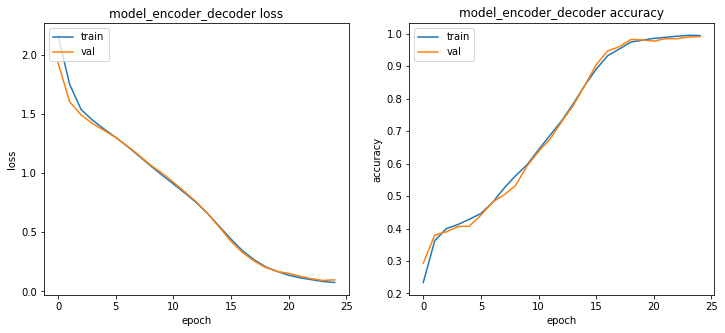

In [ ]:
train_test(model_encoder_decoder, 
           X_train, y_train , 
           X_test, y_test, 
           batch_size=batch_size,
           epochs=25,
           patience=3)

## Does it work for longer sequences? (timesteps=20, features=20)

In [ ]:
##################
# YOUR CODE HERE #
##################

# Attention!

## How does it work?

In [ ]:
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)

Epoch 1/100
180/180 [==============================] - 12s 21ms/step - loss: 2.0989 - accuracy: 0.2700 - val_loss: 1.8006 - val_accuracy: 0.3600
Epoch 2/100
180/180 [==============================] - 1s 8ms/step - loss: 1.6174 - accuracy: 0.3932 - val_loss: 1.5164 - val_accuracy: 0.4037
Epoch 3/100
180/180 [==============================] - 1s 8ms/step - loss: 1.4426 - accuracy: 0.4108 - val_loss: 1.4011 - val_accuracy: 0.4113
Epoch 4/100
180/180 [==============================] - 1s 8ms/step - loss: 1.3645 - accuracy: 0.4268 - val_loss: 1.3389 - val_accuracy: 0.4238
Epoch 5/100
180/180 [==============================] - 1s 8ms/step - loss: 1.3027 - accuracy: 0.4403 - val_loss: 1.2788 - val_accuracy: 0.4437
Epoch 6/100
180/180 [==============================] - 1s 8ms/step - loss: 1.2363 - accuracy: 0.4665 - val_loss: 1.2089 - val_accuracy: 0.4888
Epoch 7/100
180/180 [==============================] - 1s 7ms/step - loss: 1.1556 - accuracy: 0.5028 - val_loss: 1.1115 - val_accuracy: 0.51

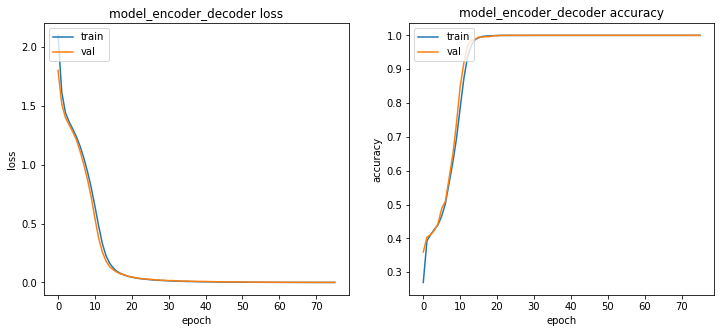

In [ ]:
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

Epoch 1/100
180/180 [==============================] - 12s 21ms/step - loss: 2.1043 - accuracy: 0.2808 - val_loss: 1.7950 - val_accuracy: 0.3475
Epoch 2/100
180/180 [==============================] - 1s 8ms/step - loss: 1.6241 - accuracy: 0.3921 - val_loss: 1.5914 - val_accuracy: 0.3887
Epoch 3/100
180/180 [==============================] - 2s 8ms/step - loss: 1.5011 - accuracy: 0.4085 - val_loss: 1.4886 - val_accuracy: 0.4050
Epoch 4/100
180/180 [==============================] - 2s 8ms/step - loss: 1.4120 - accuracy: 0.4215 - val_loss: 1.4154 - val_accuracy: 0.4163
Epoch 5/100
180/180 [==============================] - 1s 8ms/step - loss: 1.3392 - accuracy: 0.4372 - val_loss: 1.3385 - val_accuracy: 0.4275
Epoch 6/100
180/180 [==============================] - 1s 7ms/step - loss: 1.2641 - accuracy: 0.4664 - val_loss: 1.2561 - val_accuracy: 0.4587
Epoch 7/100
180/180 [==============================] - 2s 8ms/step - loss: 1.1734 - accuracy: 0.5088 - val_loss: 1.1451 - val_accuracy: 0.51

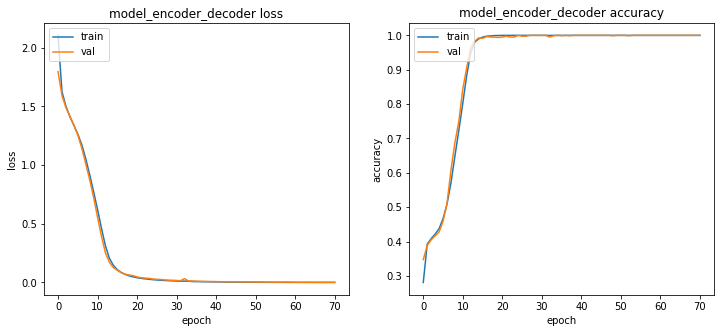

In [ ]:
n_timesteps_in = 4  # Sequence length
n_features = 10     # Maximum number allowed-1 (length of the one-hot-encoded vector)
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units)
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=100, patience=3)